In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
import numpy.ma as ma

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16

In [2]:
#random trigger data
ptrigDF = pd.read_pickle(r'Cosmic_Runs_Run6_list.pkl')
#cosmic data
cosmic_df = pd.read_pickle(r'Cosmic_Runs_Run5_list.pkl')

#set to 1 for 4k files, 2 for 8k files
ADCmult = 1

#All hits below this threshold are set to zero
MIPCut = 0.3

#Apply MIP scaling and pedestal ADC value here for simulation

#ADCs per MIP for simulation, set to 1 if the file is in units of MIPs
ADCtoMIP = 1

#Pedestal value for simulation, in whatever units the file is in
SimPedestal = 0

simPedMeans = np.full(40, SimPedestal)
simMips = np.full(40, ADCtoMIP)

In [3]:
print(ptrigDF)

       Ch_00_LG  Ch_00_HG  Ch_01_LG  Ch_01_HG  Ch_02_LG  Ch_02_HG  Ch_03_LG  \
0          44.0      32.0      44.0      25.0      37.0      31.0      39.0   
1          51.0      47.0      39.0      47.0      36.0      31.0      41.0   
2          43.0      36.0      44.0      27.0      42.0      17.0      40.0   
3          47.0      71.0      48.0      78.0      51.0      74.0      48.0   
4          48.0      58.0      47.0      56.0      42.0      52.0      37.0   
...         ...       ...       ...       ...       ...       ...       ...   
10535      45.0      52.0      39.0      34.0      42.0      48.0      42.0   
10536      46.0      71.0      45.0      62.0      49.0      58.0      50.0   
10537      47.0     102.0      43.0     104.0      47.0      93.0      37.0   
10538      45.0      70.0      38.0      70.0      42.0      60.0      38.0   
10539      45.0      59.0      43.0      44.0      40.0      36.0      41.0   

       Ch_03_HG  Ch_04_LG  Ch_04_HG  ...  Ch_18_HG 

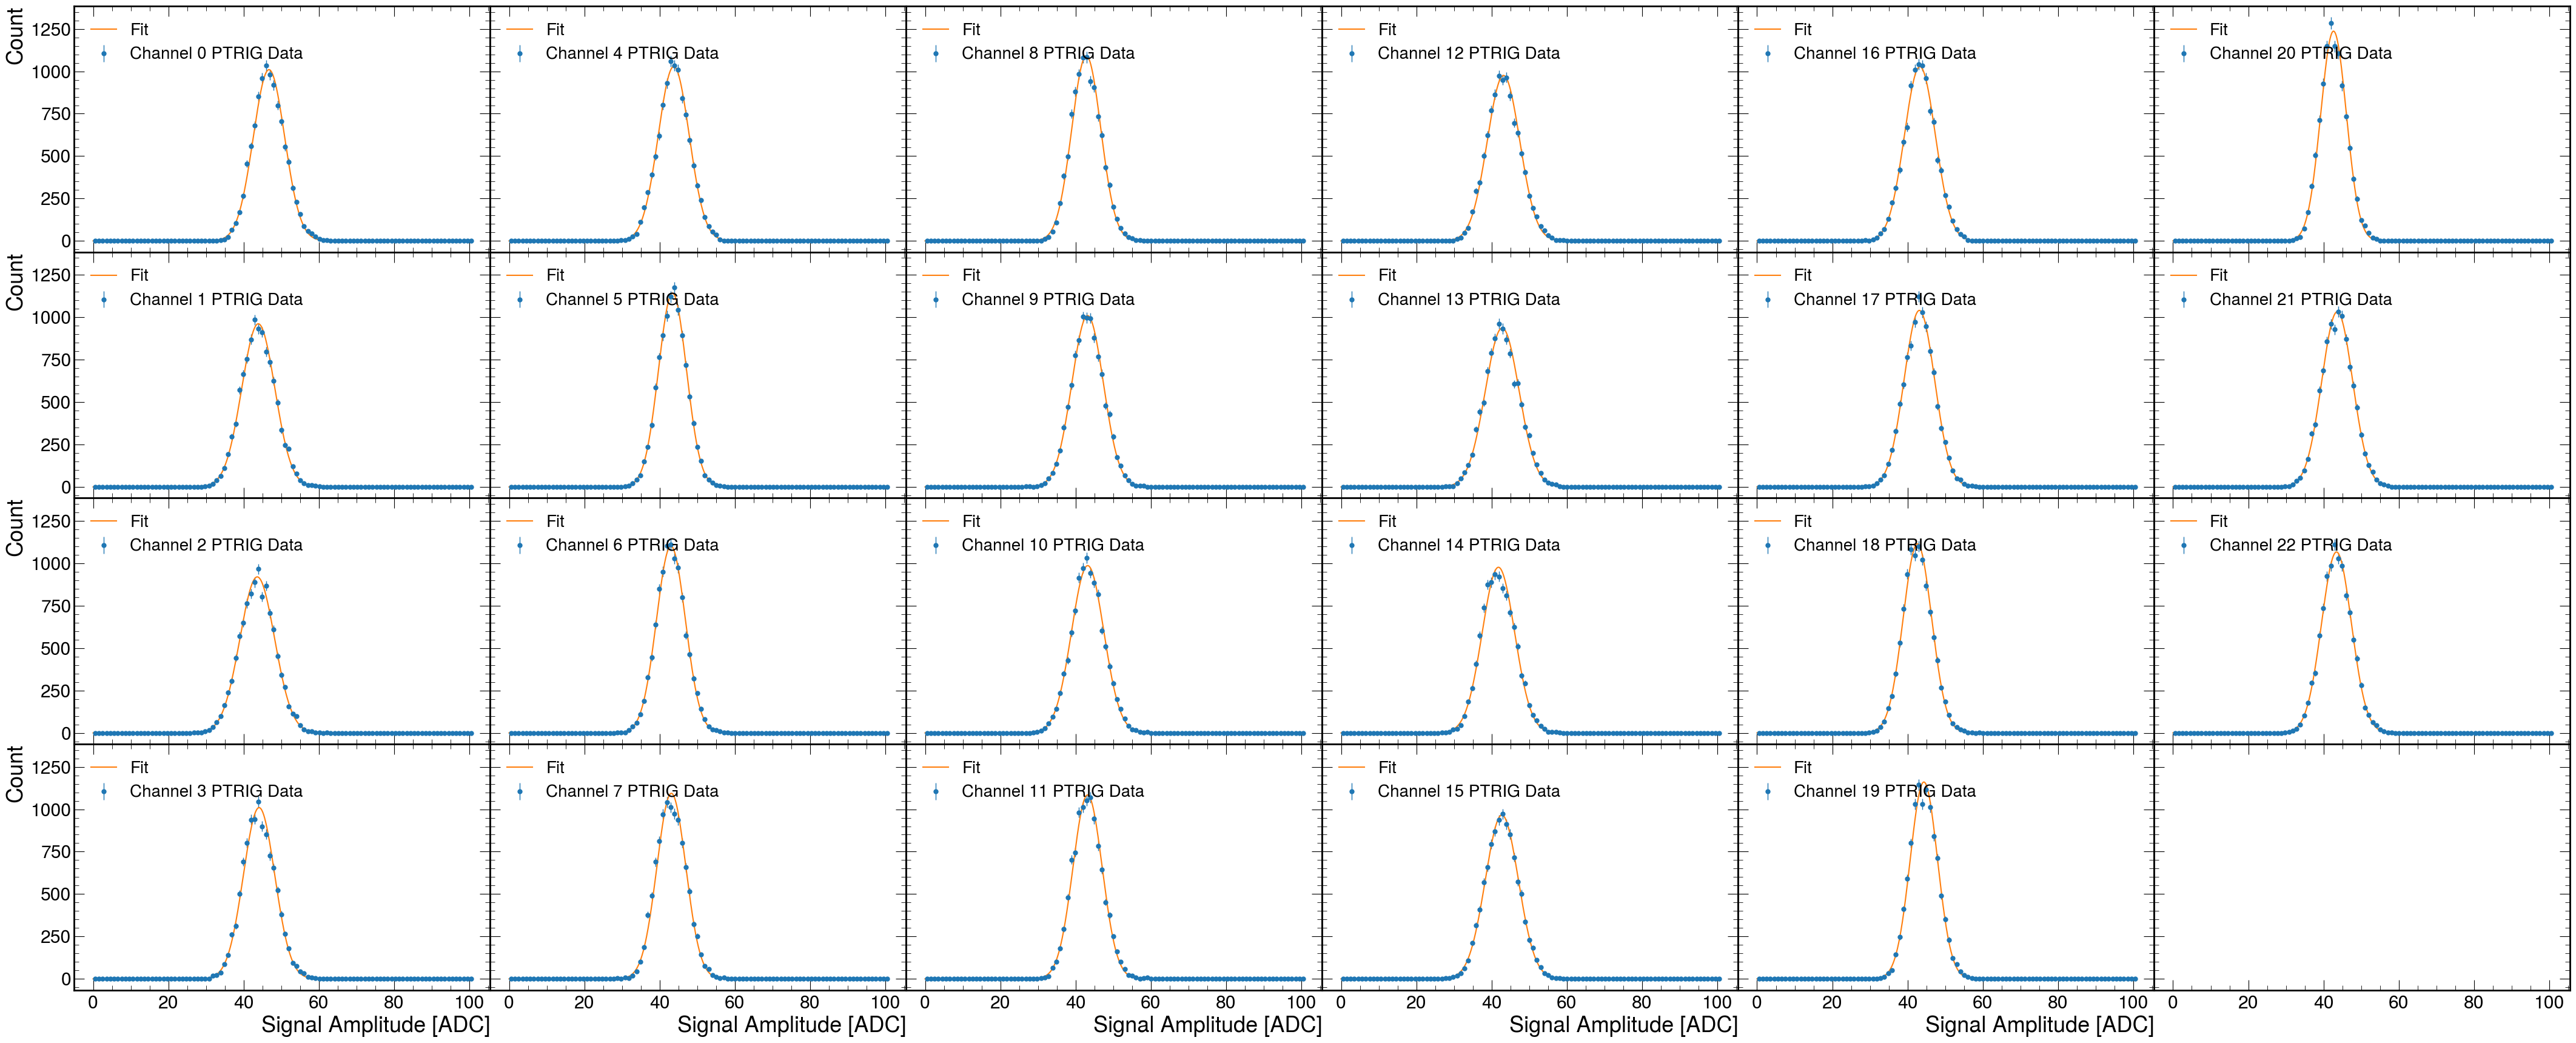

In [4]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 6, figsize=(0.9*len(cosmic_df.columns),17),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    #u = (x - mu)*3.591/(sigma/2.355)
    #Aprime = 1.648*A
    #return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

pedMeans = []
pedStds = []

for i in range(23):
    plt.sca(axs[i%4][i//4])
    
    h = hist.Hist(hist.axis.Regular(100, 0, 101, name="Ptrig"))
    h.fill(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))))
    #h.plot(color='blue',label=f"Channel {i} PTRIG Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} PTRIG Data")

    # Initial parameter values for the fit
    initial_params = [max(h), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 3.]
    #initial_params = [10000,43,2.5]
    # Create Minuit object and set up the fit
    #new code below
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    m = Minuit(LeastSquares(x, y, yerr, gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    x = np.linspace(0, 100, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper left', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
  
    #plt.yscale("log") 
    
    pedMeans.append(mu_fit)
    pedStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Average mean value:
43.375830031384545
Average width value:
4.069280013200796
[46.728640176493236, 43.89094486984034, 43.613574173289805, 44.097911150204716, 43.749144552230995, 43.42120443100121, 42.99769640111068, 43.11373613053227, 42.836725329147384, 43.18511596458817, 43.21063653172667, 43.17578193850534, 43.17601889784868, 42.81640329271583, 41.81632779908729, 42.727209366324026, 43.27782733360089, 43.13306071870445, 42.614932102616315, 44.33279925715259, 42.65386587368655, 43.63260758315127, 43.44192684828602]
[4.167692153230368, 4.389266973184517, 4.5973077098828705, 4.164826708241769, 4.112313531282352, 3.7100132323810042, 3.8393917516209175, 3.8318143558748554, 3.861789032114058, 4.18973018979959, 4.291393956155469, 3.8823539558438087, 4.31100139010353, 4.478127994173403, 4.3087991929973875, 4.381624683466186, 4.115227549986877, 4.068146532834175, 3.7926261495961375, 3.630276839098766, 3.4042719790545206, 4.099216151845813, 3.9662282908499336]


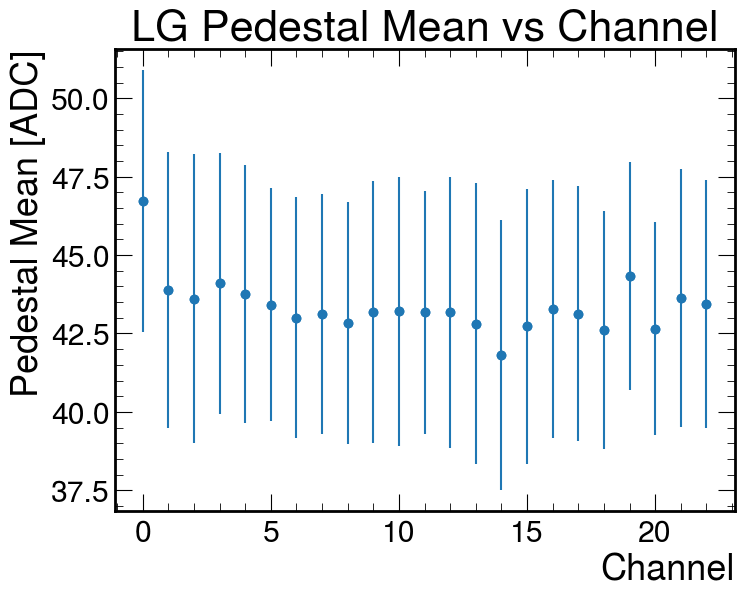

In [5]:
#plot pedestals means and stds for low gain

fig = plt.figure( figsize=(8, 6))
plt.scatter(range(0,23),pedMeans)
plt.xlabel('Channel')
plt.ylabel('Pedestal Mean [ADC]')
plt.title("LG Pedestal Mean vs Channel")
plt.errorbar(range(0,23), pedMeans, yerr=pedStds, fmt="o")
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))
#new codes below
print(pedMeans)
print(pedStds)

[ 75.27135982  81.27135982 213.27135982 ...  34.27135982 135.27135982
  82.27135982]
[62.10905513 66.10905513 84.10905513 ... 41.10905513 54.10905513
 48.10905513]
[ 66.38642583  61.38642583  61.38642583 ...  71.38642583 119.38642583
  59.38642583]
[62.90208885 87.90208885 86.90208885 ... 70.90208885 57.90208885
 37.90208885]
[ 60.25085545  96.25085545 152.25085545 ...  85.25085545  77.25085545
  32.25085545]
[16.57879557 81.57879557 17.57879557 ... 54.57879557 38.57879557
 43.57879557]
[ 63.0023036 109.0023036  77.0023036 ... 109.0023036 154.0023036
  42.0023036]
[98.88626387 34.88626387 15.88626387 ... 82.88626387 40.88626387
 60.88626387]
[ 71.16327467 149.16327467  59.16327467 ...  84.16327467  83.16327467
  46.16327467]
[ 71.81488404  97.81488404  71.81488404 ... 141.81488404  71.81488404
  59.81488404]
[ 53.78936347  58.78936347 258.78936347 ...  96.78936347 125.78936347
  53.78936347]
[ 46.82421806  81.82421806 103.82421806 ...  42.82421806  51.82421806
  45.82421806]
[ 58.82398

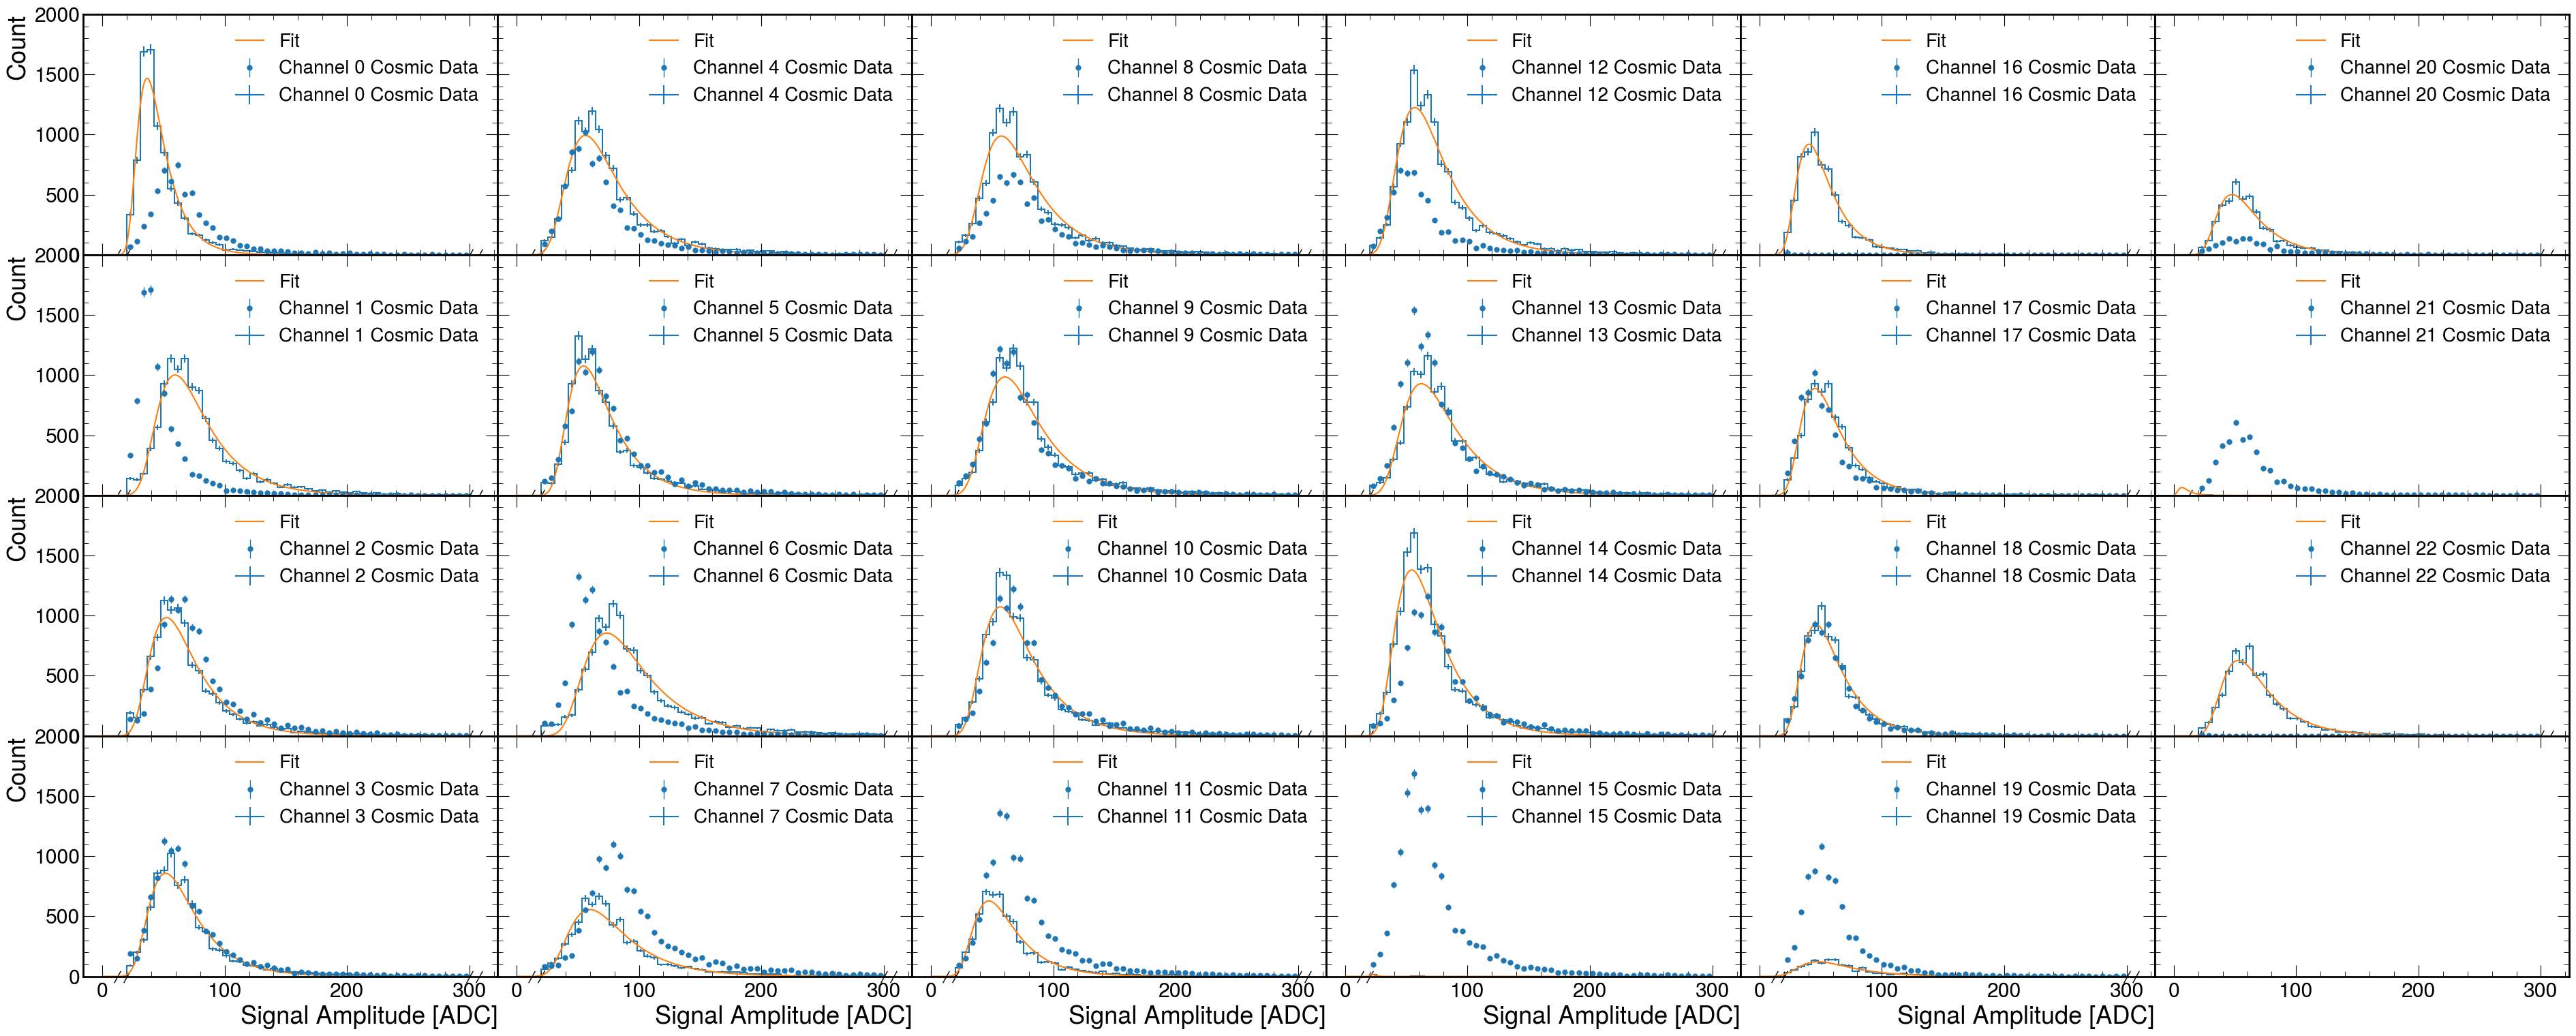

In [14]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 6, figsize=(0.8*len(cosmic_df.columns),15),sharey=True,sharex=True)
#fig, axs = plt.subplots(4, 6, figsize=(15, 10), sharey=True, sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

mips = []
mipStds = []

def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)
#def get_mu_error(error_params):

    #mips = []
    #mipStds = []

for i in range(23):
    cosmicCh = np.array(getattr(cosmic_df, "Ch_{}_LG".format("{:02d}".format(i))))
    cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] * 4) + pedMeans[i]] - pedMeans[i]
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 20, 300, name="Ptrig"))
    
    #cosmicCh = np.array(getattr(cosmic_df,"Ch_{}_LG".format("{:02d}".format(i))))
   #cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] *4)+pedMeans[i]] - pedMeans[i]
    print(cosmicCh)
  #the logic of the cut is that the cosmic chanel has to be less than or equal to the (ped standard X 4) plus the ped means @index i - pedmeans @index i
   #here is an array
    
    
    h.fill(cosmicCh)
    plt.errorbar(bins, data, yerr=np.sqrt(data), fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0, label=f"Channel {i} Cosmic Data")
    h.plot(color='tab:blue',label=f"Channel {i} Cosmic Data")  #comment
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    
    #plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")

    
    # Find the bin number with the maximum value
    max_bin_number = np.argmax(h.values())

    # Get the axis from the histogram
    axis = h.axes[0]

    # Find the x-coordinate corresponding to the maximum bin
    x_coordinate = axis.edges[max_bin_number]
    mips.append(x_coordinate)
    
    # Initial parameter values for the fit
    initial_params = [max(h), np.mean(cosmicCh), np.std(cosmicCh)]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    cost = LeastSquares(x, y, yerr, landau)
    m = Minuit(cost, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (0, 200)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A'] #amp
    mu_fit = fitted_params['mu'] #mean of fitted function, we love her
    sigma_fit = fitted_params['sigma']#width we dont care about her

    #mu_std = np.std(mips)
    x_fit = np.linspace(0, 300, 1000)
    y_fit = landau(x_fit, A_fit, mu_fit, sigma_fit)
    plt.plot(x_fit, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
        
    mu_err = sigma_fit
        
    mips.append(mu_fit)
    mipStds.append(mu_err)


# Adjust the spacing between subplots
plt.ylim(0,2000)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

print("mips:", mips)
print("mipStds:", mipStds)

Average mean value:
50.21370788871446
Average width value:
102.70361463852876
[36.8        36.63616036 53.6        59.50439262 48.         52.53862696
 53.6        51.68755431 59.2        56.26684976 55.50172342 54.71049174
 76.         73.68005217 64.8        55.50172342 53.6        57.64830203
 49.47756543 60.58726837 53.6        56.86511357 42.4        47.3592198
 53.6        56.94495719 49.47756543 62.23886118 53.6        54.40175669
 20.         49.47756543 42.4        40.39718169 42.4        45.3221351
 48.         46.12704797 53.6        47.93703046 48.         47.60120587
 20.          6.72564816 59.2        52.81456373]
[65.32671601184549, 120.24180367535385, 111.0776358597363, 109.21336836225008, 123.01146249292367, 103.73774640308736, 147.85191688916115, 135.65808713870044, 123.30702602000937, 128.1847964601637, 118.7114182525252, 99.67309841128844, 114.45014502181053, 125.9023466203827, 108.36579660912187, 10.072509304328342, 81.23527761999766, 92.4081881595175, 92.89870051

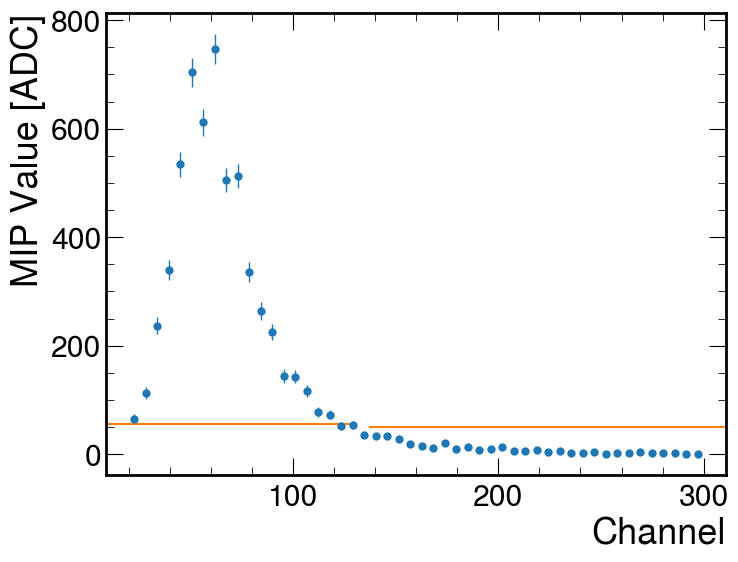

In [17]:
mips = np.array(mips)

# Section 1
section1 = mips[0:16]
excluded_indexes1 = [10, 15]
mask1 = np.ones_like(section1, dtype=bool)
mask1[excluded_indexes1] = False
mips[10] = np.mean(section1[mask1])
mips[15] = np.mean(section1[mask1])

# Section 2
section2 = mips[16:40]
excluded_indexes2 = [2,10,15]
mask2 = np.ones_like(section2, dtype=bool)
mask2[excluded_indexes2] = False
mips[18] = np.mean(section2[mask2])
mips[26] = np.mean(section2[mask2])
mips[31] = np.mean(section2[mask2])

fig = plt.figure( figsize=(8, 6))
#plt.errorbar(range(0,15), mips[0:15], yerr=mipStds[0:15], fmt="o", color = "green")
#plt.errorbar(range(15,16), mips[15:16], yerr=mipStds[15:16], fmt="o", color = "red")
#plt.errorbar(range(16,21), mips[16:21], yerr=mipStds[16:21], fmt="o", color = "blue")
#plt.errorbar(range(21,23), mips[21:23], yerr=mipStds[21:23], fmt="o", color = "purple")
plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")


plt.xlabel('Channel')
plt.ylabel('MIP Value [ADC]')

plt.axhline(y = np.mean(section1[mask1]), color = 'tab:orange', xmax = 16/40)
plt.axhline(y = np.mean(section2[mask2]), color = 'tab:orange', xmin = 17/40)

print("Average mean value:")
print(np.mean(mips))
print("Average width value:")
print(np.mean(mipStds))
print(mips)
print(mipStds)

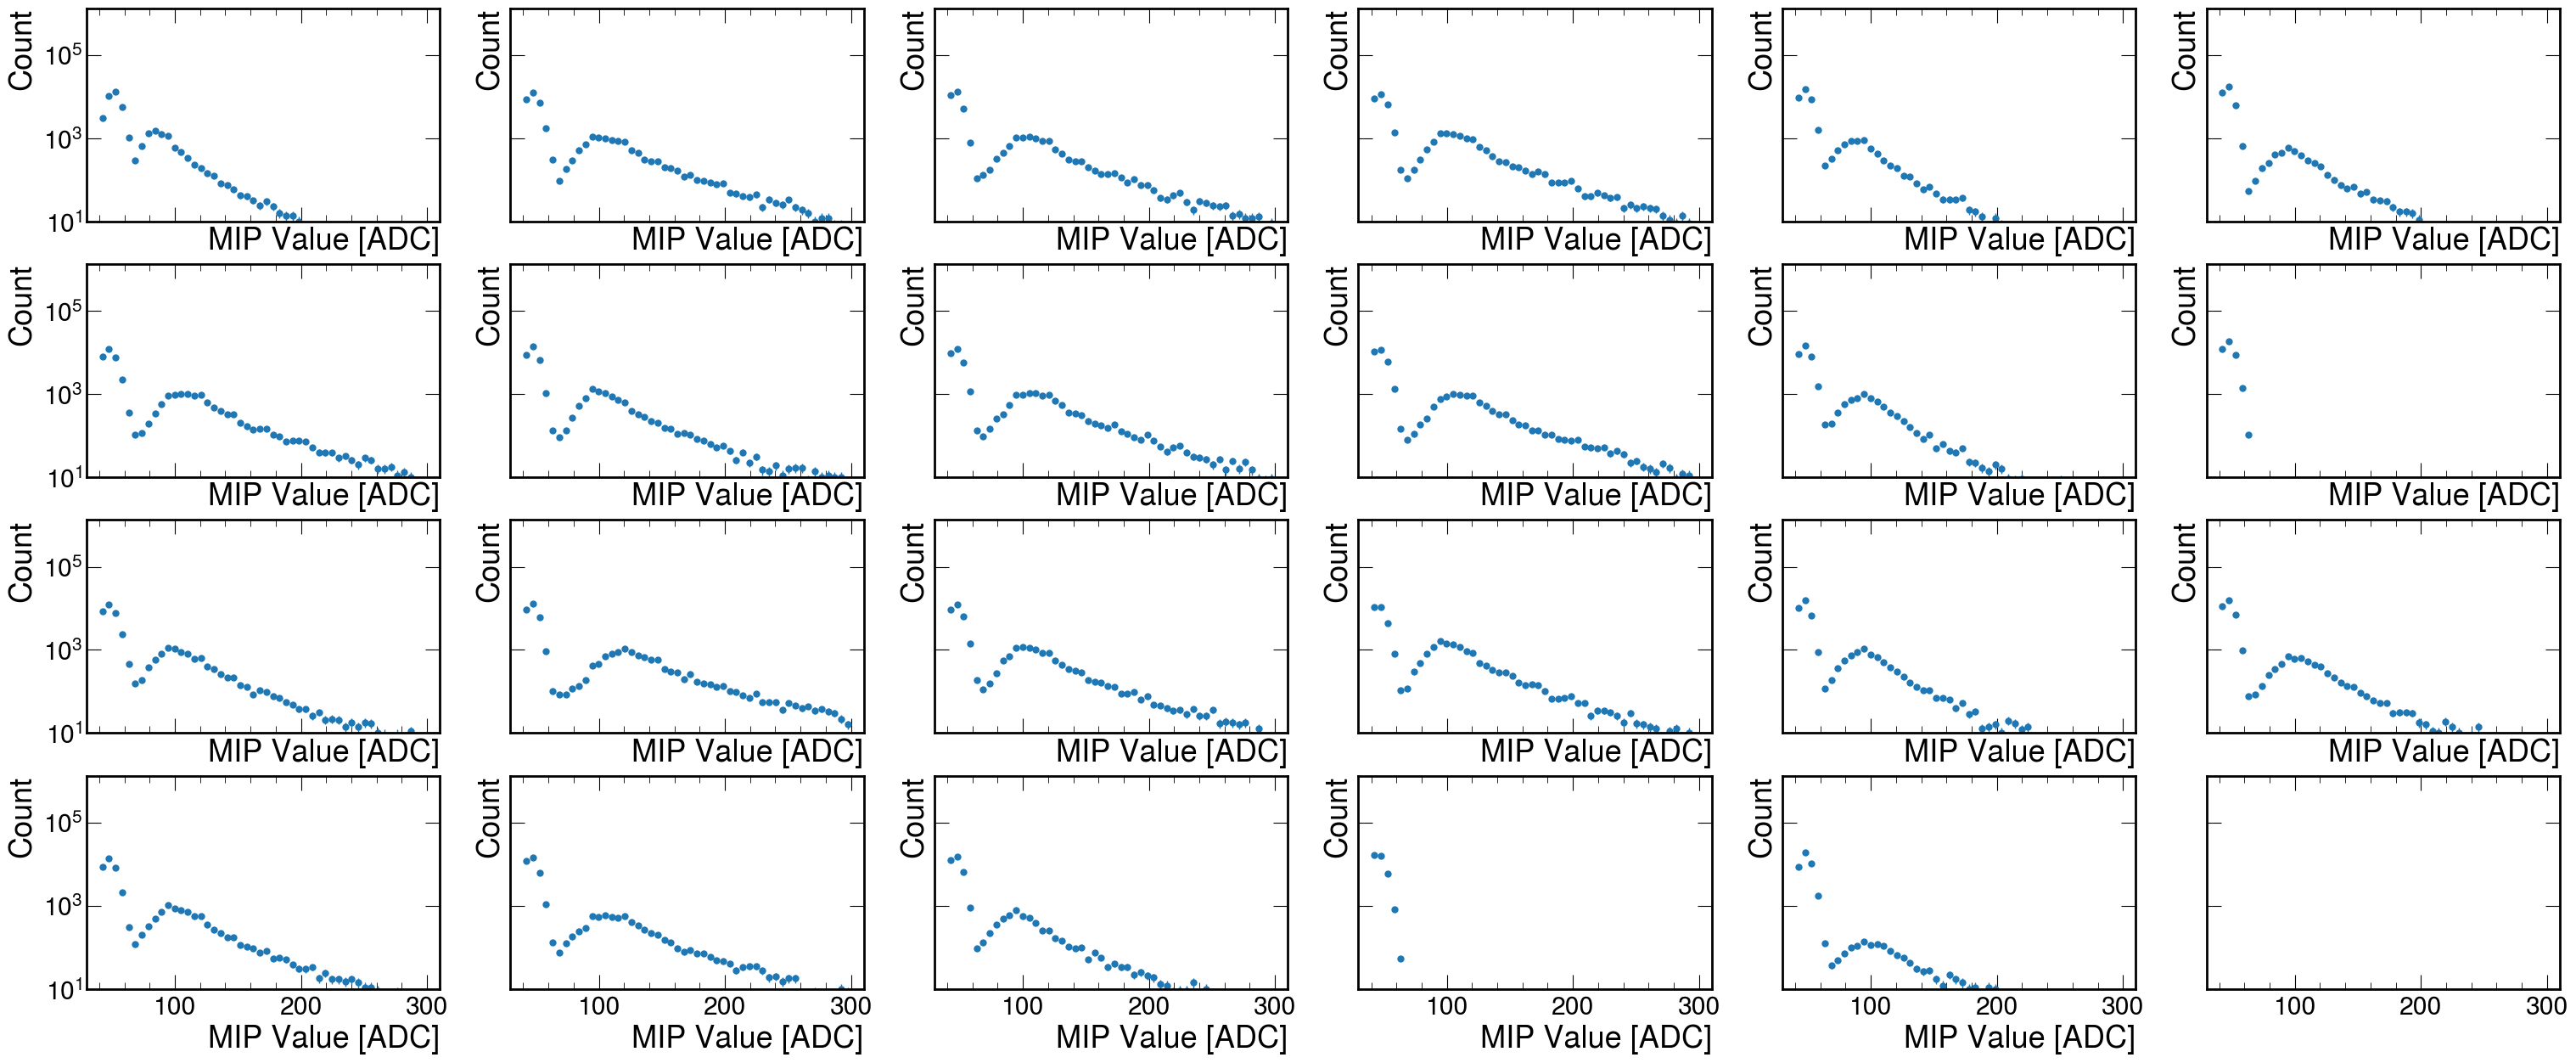

In [18]:
fig, axs=plt.subplots(4, 6, figsize=(0.8*len(cosmic_df.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

mips = []
mipStds = []

for i in range(23):
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 40, 300, name="Ptrig"))
    
    cosmicCh = np.array(getattr(cosmic_df,"Ch_{}_LG".format("{:02d}".format(i))))
   
    h.fill(cosmicCh)
    #h.plot(color='tab:blue',label=f"Channel {i} Cosmic Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

    
    data = h.values()[()]
    bins = bin_centers
    plt.ylim(10,1350000)

    plt.ylabel('Count')
    plt.xlabel('MIP Value [ADC]')
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i}Cosmic Data")
    plt.yscale("log")